## importing all the required libraries from train.py

In [1]:
# from train.py:

import argparse
import math
import os
import random
import subprocess
import sys
import time
from copy import deepcopy
from datetime import datetime, timedelta
from pathlib import Path

try:
    import comet_ml  # must be imported before torch (if installed)
except ImportError:
    comet_ml = None

import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import yaml
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision

FILE = Path("C:\\Users\\kruth\\yolov5_from_scratch\\yolov5\\train.py").resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

import val as validate  # for end-of-epoch mAP
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.autobatch import check_train_batch_size
from utils.callbacks import Callbacks
from utils.dataloaders import create_dataloader
from utils.downloads import attempt_download, is_url
from utils.general import (
    LOGGER,
    TQDM_BAR_FORMAT,
    check_amp,
    check_dataset,
    check_file,
    check_git_info,
    check_git_status,
    check_img_size,
    check_requirements,
    check_suffix,
    check_yaml,
    colorstr,
    get_latest_run,
    increment_path,
    init_seeds,
    intersect_dicts,
    labels_to_class_weights,
    labels_to_image_weights,
    methods,
    one_cycle,
    print_args,
    print_mutation,
    strip_optimizer,
    yaml_save,
)
from utils.loggers import LOGGERS, Loggers
from utils.loggers.comet.comet_utils import check_comet_resume
from utils.loss import ComputeLoss
from utils.metrics import fitness
from utils.plots import plot_evolve
from utils.torch_utils import (
    EarlyStopping,
    ModelEMA,
    de_parallel,
    select_device,
    smart_DDP,
    smart_optimizer,
    smart_resume,
    torch_distributed_zero_first,
)

LOCAL_RANK = int(os.getenv("LOCAL_RANK", -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv("RANK", -1))
WORLD_SIZE = int(os.getenv("WORLD_SIZE", 1))
GIT_INFO = check_git_info()


## coco dataset labels

In [2]:
coco_idx_to_label = {
    0: "person", 1: "bicycle", 2: "car", 3: "motorcycle", 4: "airplane", 5: "bus", 6: "train", 7: "truck", 8: "boat", 9: "traffic light",
    10: "fire hydrant", 11: "stop sign", 12: "parking meter", 13: "bench", 14: "bird", 15: "cat", 16: "dog", 17: "horse", 18: "sheep", 19: "cow",
    20: "elephant", 21: "bear", 22: "zebra", 23: "giraffe", 24: "backpack", 25: "umbrella", 26: "handbag", 27: "tie", 28: "suitcase", 29: "frisbee",
    30: "skis", 31: "snowboard", 32: "sports ball", 33: "kite", 34: "baseball bat", 35: "baseball glove", 36: "skateboard", 37: "surfboard", 38: "tennis racket", 39: "bottle", 40: "wine glass", 41: "cup", 42: "fork", 43: "knife", 44: "spoon", 45: "bowl", 46: "banana", 47: "apple", 48: "sandwich", 49: "orange",
    50: "broccoli", 51: "carrot", 52: "hot dog", 53: "pizza", 54: "donut", 55: "cake", 56: "chair", 57: "couch", 58: "potted plant", 59: "bed",
    60: "dining table", 61: "toilet", 62: "tv", 63: "laptop", 64: "mouse", 65: "remote", 66: "keyboard", 67: "cell phone", 68: "microwave", 69: "oven",
    70: "toaster", 71: "sink", 72: "refrigerator", 73: "book", 74: "clock", 75: "vase", 76: "scissors", 77: "teddy bear", 78: "hair drier", 79: "toothbrush"
}

## to display images with bb and labels

In [3]:
# SHow the image with the bounding boxes and labels
def show_image(image, label=None): # i/p is the image tensor, label is a list in YOLO format (x_center, y_center, width, height, class)
    if label is not None: # Draw labels on image
        boxes = torchvision.ops.box_convert(boxes=label[:, 2:] * 640, in_fmt="cxcywh", out_fmt="xyxy")  #conversion to  top-left (x1, y1) and bottom-right (x2, y2).
        classes = [] #to extract the class names from the coco_idx_to_label dict
        for obj in label:
            class_idx = int(obj[1].item())
            classes.append(coco_idx_to_label[class_idx])
        image = torchvision.utils.draw_bounding_boxes(image, boxes, labels=classes, colors="blue", width=2, font_size=700)
    
    image = image.permute(1, 2, 0) # PyTorch tensors are in (channels, height, width) format → Matplotlib needs (height, width, channels)
    plt.imshow(image)
    # plt.title(f'Label: {label}')
    plt.show()


## setup for training the model

In [4]:
# paths for the dataset
train_path = "C:\\Users\\kruth\\Datasets\\coco128\\images\\train2017"
val_path = "C:\\Users\\kruth\\Datasets\\coco128\\images\\train2017"

# Hyperparameters
imgsz = 640 # (640x640) pixels
batch_size = 1 # is the no. of images per trianing batch. At every batch, 1 forward pass and 1 backward pass is done with 1 image (here).
WORLD_SIZE = 1 # single GPU
gs = 32  # grid size, aka max stride, this ensures that hte images are resized to match the stride of the network.
single_cls = False # is true iff the dataset has only one class

# other hyperparameters
hyp = {
    "lr0": 0.01, # initial learning rate
    "lrf": 0.01, # final learning rate
    "momentum": 0.937,  # momentum for Stochastic Gradient Descent (SGD) optimizer
    "weight_decay": 0.001, # is the "lambda" parameter in the L2 regularization term
    "warmup_epochs": 3.0, # no. of epochs for for increasing the learning rate from lr0 to lrf?
    "warmup_momentum": 0.8, 
    "warmup_bias_lr": 0.1,
    "box": 0.05, # is the weight for the bounding box loss
    "cls": 0.5, # is the weight for the classification loss
    "cls_pw": 1.0, # Classification loss positive weight
    "obj": 1.0, # is the weight for the objectness loss
    "obj_pw": 1.0,  # is the objectness loss positive weight
    "iou_t": 0.2, # is the Intersection over Union (IOU) threshold for the loss function
    "anchor_t": 4.0, # is the anchor matching threshold
    "fl_gamma": 0.0, 

    # Augmentation hyperparameters
    "hsv_h": 0.015, # Hue factor
    "hsv_s": 0.7, # Saturation
    "hsv_v": 0.4, # brightness
    "degrees": 0.0,   # image rotation 
    "translate": 0.1, # image translation to the left or right
    "scale": 0.5, # image scaling
    "shear": 0.0, # image shearing
    "perspective": 0.0, # image perspective
    "flipud": 0.0, # flip the image upside down
    "fliplr": 0.5, # flip the image left to right - w.p. 50% here

    # Mosaic, Mixup, Copy-Paste augmentation hyperparameters
    "mosaic": 0.0, # is the weight for the mosaic augmentation - combine 4 images into 1 
    "mixup": 0.0,   # mixup augmentation for blending 2 images
    "copy_paste": 0.0 # copy-paste augmentation for cutting and pasting objects from one image to another
}

# Model configurations
cfg = "C:\\Users\\kruth\\yolov5_from_scratch\\yolov5\\models\\yolov5s.yaml" # model architecture present
# this defines - Backbone(CSPDarknet53), Neck(SPPF, PAN), Head(YOLOv3)
cache = None # cache images for faster training 
LOCAL_RANK = -1 # used for distributed training - GPU - (not enabled here)
workers = 8 # no. of CPU workers for dataloader 
seed = 0

# Device selection
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" # for Apple Silicon use metal API
    if torch.backends.mps.is_available()
    else "cpu"
)

# USe dataloader to load the dataset
# Creates and returns a configured DataLoader instance for loading and processing image datasets.
train_loader, dataset = create_dataloader(
    train_path, 
    imgsz,
    batch_size // WORLD_SIZE,   #  Divides batch size for multiple GPUs (if using WORLD_SIZE > 1).
    gs,
    single_cls,
    hyp=hyp,
    augment=True,
    cache=cache,
    rank=LOCAL_RANK,
    workers=workers,
    rect = False, # Use square images, not rectangular ones
    quad = False, # used in Mixed Precision Training
    prefix=colorstr('train: '),
    shuffle=True,
    seed=seed
)

train: Scanning C:\Users\kruth\Datasets\coco128\labels\train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


## understand the dataset and formats

In [5]:
# understand the structure here:
print(type(dataset))

#  Access the first sample in the dataset
sample = dataset[0] # is a tuple containing the image tensor, label tensor, image path, and metadata
print(type(sample))
print(len(sample))

# Unpack the sample
image_tensor, label_tensor, image_path, metadata = sample

# Print the shapes and types
print(f"Image Tensor Shape: {image_tensor.shape}") # 3 is the no. of channels (RGB), 640x640 is the image size
print(f"Label Tensor Shape: {label_tensor.shape}") # has 4 objects and 6 values of [image_index, class_index, x, y, w, h]
print(f"Image Path: {image_path}") # path to the image file
print(f"Metadata: {metadata}") 

# further
print(f"Label Tensor: {label_tensor}")

<class 'utils.dataloaders.LoadImagesAndLabels'>
<class 'tuple'>
4
Image Tensor Shape: torch.Size([3, 640, 640])
Label Tensor Shape: torch.Size([8, 6])
Image Path: C:\Users\kruth\Datasets\coco128\images\train2017\000000000009.jpg
Metadata: ((480, 640), ((1.0, 1.0), (0.0, 80.0)))
Label Tensor: tensor([[ 0.00000, 45.00000,  0.55617,  0.59556,  0.67296,  0.31452],
        [ 0.00000, 45.00000,  0.37516,  0.36233,  0.35132,  0.25163],
        [ 0.00000, 50.00000,  0.44520,  0.61889,  0.34797,  0.26967],
        [ 0.00000, 45.00000,  0.65479,  0.45302,  0.47808,  0.41276],
        [ 0.00000, 49.00000,  0.43832,  0.30179,  0.08313,  0.05120],
        [ 0.00000, 49.00000,  0.34937,  0.30033,  0.06390,  0.05135],
        [ 0.00000, 49.00000,  0.42321,  0.35162,  0.09245,  0.07759],
        [ 0.00000, 49.00000,  0.44112,  0.27362,  0.10427,  0.07820]])


torch.Size([3, 640, 640])
torch.Size([8, 6])
C:\Users\kruth\Datasets\coco128\images\train2017\000000000009.jpg
tensor([45., 45., 50., 45., 49., 49., 49., 49.])
['bowl', 'bowl', 'broccoli', 'bowl', 'orange', 'orange', 'orange', 'orange']


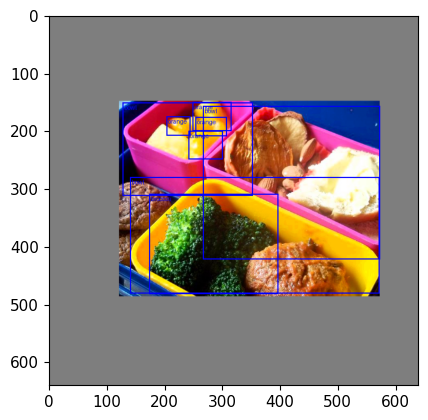

In [6]:
%matplotlib inline

# Display the first image in the dataset along with its labels and bounding boxes
x1, y1, path, _ = sample
print(x1.shape)  # 3x640x640
print(y1.shape)  # n_obj=8, 6 is [image_index, class_index, x, y, w, h]
print(path) # image path

# print the labels from y1 that map to coco_idx_to_label
print(y1[:, 1])
print([coco_idx_to_label[int(i)] for i in y1[:, 1]])

show_image(x1, y1)

torch.Size([1, 3, 640, 640])
torch.Size([2, 6])
C:\Users\kruth\Datasets\coco128\images\train2017\000000000589.jpg
tensor([0.00000e+00, 2.90000e+01, 2.31262e-01, 4.02942e-01, 3.47943e-02, 1.16909e-02])
label: frisbee


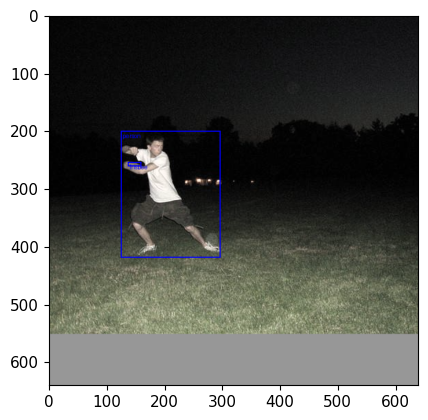

In [7]:
# Extracting Single batch from the TRAIN LOADER
for X, y, paths, _ in train_loader:
    break # get only the first batch

# y is of shape number_objs * 6
# 6: image_index, class_index, x, y, w, h

print(X.shape) # 1 is the no. of images in the batch, 3 is the no. of channels (RGB), 640x640 is the image size
print(y.shape) # has 2 objects and 6 values of [image_index, class_index, x, y, w, h]
print(paths[0]) # path to the image file
print(y[0, :]) # print the first object details

# get the label for the first object from coco_idx_to_label dict
class_idx = int(y[0, 1].item())
print(f"label: {coco_idx_to_label[class_idx]}")

show_image(X[0], y[:3]) # show the first 3 objects in the image

## Understand the model

In [8]:
# define the model 
model = Model(cfg, ch=3, nc=80, anchors=hyp.get('anchors')).to(device) # model is created and loaded to device (cpu here)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1   1182720  

## Forward Pass

In [9]:
# preprocessing the single image to load it to the model
# 1. to device - moves the image tensor to the device (cpu here)
# 2. float() - converts the image tensor to float data type
# 3. / 255 - normalizes the pixel values form [0,255] to [0, 1]
X = X.to(device).float() / 255  

print("X shape:", X.shape)
print(X)

X shape: torch.Size([1, 3, 640, 640])
tensor([[[[0.01176, 0.01961, 0.02353,  ..., 0.06275, 0.05098, 0.05882],
          [0.02353, 0.02745, 0.03529,  ..., 0.07843, 0.05882, 0.05882],
          [0.02353, 0.02745, 0.02745,  ..., 0.06275, 0.05882, 0.06275],
          ...,
          [0.59216, 0.59216, 0.59216,  ..., 0.59216, 0.59216, 0.59216],
          [0.59216, 0.59216, 0.59216,  ..., 0.59216, 0.59216, 0.59216],
          [0.59216, 0.59216, 0.59216,  ..., 0.59216, 0.59216, 0.59216]],

         [[0.01176, 0.01961, 0.02353,  ..., 0.06275, 0.05098, 0.05882],
          [0.02353, 0.02745, 0.03529,  ..., 0.07843, 0.05882, 0.05882],
          [0.02353, 0.02745, 0.02745,  ..., 0.06275, 0.05882, 0.06275],
          ...,
          [0.59216, 0.59216, 0.59216,  ..., 0.59216, 0.59216, 0.59216],
          [0.59216, 0.59216, 0.59216,  ..., 0.59216, 0.59216, 0.59216],
          [0.59216, 0.59216, 0.59216,  ..., 0.59216, 0.59216, 0.59216]],

         [[0.01176, 0.01961, 0.02353,  ..., 0.07059, 0.05882, 0.

### final output after 1 forward pass

In [10]:
# Get the prediction from the model (the initial are random)

pred = model(X) # forward pass output of the model
# preds contains three feature maps from different scales: YOLOv5 outputs predictions at three scales (small, medium, large objects)
print(f"length of prediction: {len(pred)}") 
print("feature map1:", pred[0].shape) # 80x80 grid size - detect small objects (each cell has very less area comparatively)
print("feature map2:", pred[1].shape) # 40x40 grid size - detect medium objects
print("feature map3:", pred[2].shape) # 20x20 grid size - detect large objects
 
# each of the feature map has: [batch_size, num_anchors, grid_size, grid_size, (nc+5)]
# nc + 5 = 85 (80 classes + 4 bbox coordinates + 1 object confidence score)
# each grid cell has 3 anchors, so num_anchors = 3

length of prediction: 3
feature map1: torch.Size([1, 3, 80, 80, 85])
feature map2: torch.Size([1, 3, 40, 40, 85])
feature map3: torch.Size([1, 3, 20, 20, 85])


### breakdown of the forward pass

In [12]:
# 1st Conv Layer of Backbone
print("Initial shape of image passed to model:\t \t", X.shape)   
x1 = model.model[0](X) # pass through first layer of the backbone
print("Shape of the output of the 1st Conv Layer:\t", x1.shape, "\n") 
print("The first layer of the model is:\n ", model.model[0])

Initial shape of image passed to model:	 	 torch.Size([1, 3, 640, 640])
Shape of the output of the 1st Conv Layer:	 torch.Size([1, 32, 320, 320]) 

The first layer of the model is:
  Conv(
  (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)


#### Calculation involved:
1. Conv2d: #ch = 3, #filters = 32, kernel_size = 6x6, stride = 2, padding = 2:
- h_out = (h_in + 2*padding - kernel_size) / stride + 1 = (640 + 2*2 - 6) / 2 + 1 = 320
- w_out = (w_in + 2*padding - kernel_size) / stride + 1 = (640 + 2*2 - 6) / 2 + 1 = 320
- 32 filters are applied to the input image of size 640x640x3 to get the output of size 320x320x32

2. BatchNorm2d: 32 channels are normalized:
- Batch Normalization normalizes the input to a given layer for each mini-batch. Specifically:
- For each feature map, it calculates the mean and variance over the batch and normalizes the values.
- This helps mitigate issues like internal covariate shift (when the distribution of activations changes as the model trains).
- It also acts as a regularizer, reducing the need for Dropout.

3. SiLU (Swish Activation Function): SiLU(x) = x * sigmoid(x)
- It is a smooth, non-monotonic activation function that is differentiable everywhere.


In [13]:
# 2nd Layer of Backbone
x2 = model.model[1](x1) # pass through second layer of the backbone
print("Shape of the output of the 1st Conv Layer:\t", x1.shape) 
print("Shape of the output of the 2nd Conv Layer:\t", x2.shape, "\n")
print("The second layer of the model is:\n ", model.model[1])

Shape of the output of the 1st Conv Layer:	 torch.Size([1, 32, 320, 320])
Shape of the output of the 2nd Conv Layer:	 torch.Size([1, 64, 160, 160]) 

The second layer of the model is:
  Conv(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)


In [14]:
# 3rd Layer of Backbone
x3 = model.model[2](x2) # pass through third layer of the backbone
print("Shape of the output of the 2nd Conv Layer:\t", x2.shape)
print("Shape of the output of the 3rd Conv Layer:\t", x3.shape, "\n")
print("The third layer of the model is:\n ", model.model[2])

Shape of the output of the 2nd Conv Layer:	 torch.Size([1, 64, 160, 160])
Shape of the output of the 3rd Conv Layer:	 torch.Size([1, 64, 160, 160]) 

The third layer of the model is:
  C3(
  (cv1): Conv(
    (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): Sequential(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, ep

and so on...

### To visualize the entire architecture of the model

In [17]:
# Export the model to onnx format

# create a dummy input tensor
dummy_input = torch.randn(1, 3, 640, 640).to(device)

# export to ONNX
torch.onnx.export(model, 
                dummy_input, 
                "yolov5s.onnx", 
                opset_version=11,
                #do_constant_folding=False, #prevent folding of batch norm into conv,
                input_names=['input'],
                output_names=['output'],
)

# will be saved as yolov5s.onnx in the current directory


c:\Users\kruth\yolov5_from_scratch\yolov5\models\yolo.py:268: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if augment:
c:\Users\kruth\yolov5_from_scratch\yolov5\models\yolo.py:171: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if visualize:
c:\Users\kruth\yolov5_from_scratch\yolov5\models\yolo.py:167: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to oth

In [ ]:
# to visualize the output shapes, modify the model to return the output shapes
import onnx
path = "C:\\Users\\kruth\\yolov5_from_scratch\\yolov5\\yolov5s.onnx"
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(path)), path)